In [1]:
%reload_ext autoreload
%autoreload 2
import os, sys
if 'notebook_path' not in vars():
    notebook_path = os.getcwd()
os.chdir(os.path.join(notebook_path,"../.."))
sys.path.append(os.getcwd())
import glob
from scipy.io import wavfile
import configs.config_gen as config_gen
import configs.config_train as config_train
import numpy as np
from src.simulation import simulate_room_series_with_different_reverb
import configs.config_eval as config_eval
import h5py
import matplotlib.pyplot as plt
from src.DatasetTDE import DatasetTDE_eval
import torch
np.random.seed(37)

In [2]:

dataset_path = os.path.join(config_eval.dataset_target_folder ,config_eval.dataset_target_name + ".hdf5")

In [3]:
with h5py.File(dataset_path, "r") as hdf5_file:
#with h5py.File("results/datasets/eval_old.hdf5", "r") as hdf5_file:

    dX = hdf5_file["input"]
    dY = hdf5_file["gt"]
    dZ = hdf5_file["t60s"]
    

In [4]:
models = config_eval.get_models()
residuals = {model_name : np.zeros((len(config_eval.reverberations_levels), config_eval.n_rooms_simulate*(config_eval.n_mics*(config_eval.n_mics-1))//2 )) for model_name in models}
t60s = {model_name : np.zeros((len(config_eval.reverberations_levels), config_eval.n_rooms_simulate*(config_eval.n_mics*(config_eval.n_mics-1))//2 )) for model_name in models}
with h5py.File(dataset_path, "r") as hdf5_file:
#with h5py.File("results/datasets/eval_old.hdf5", "r") as hdf5_file:

    dX = hdf5_file["input"]
    dY = hdf5_file["gt"]
    dZ = hdf5_file["t60s"]
    
    for i in range(len(config_eval.reverberations_levels)):
    #for i in [8]:#range(2):
        print("new_reverb")
        d = DatasetTDE_eval(dX[:,i],dY,t60=dZ[:,i],use_t60=True)
        dl = torch.utils.data.DataLoader(d, batch_size=config_train.batch_size)
        counter = 0
        for X,y,t60 in dl:
            print("-")
            X += X.std(dim=2,keepdim=True)/10**(config_eval.snr_at_reverb_measurement/20)
            X,y = X.to(config_eval.device),y.to(config_eval.device)
            for j, model_name in enumerate(models):
                res = models[model_name](X).argmax(1) - (y + 500)
                residuals[model_name][i,counter: counter + X.shape[0]] = res.cpu()
                t60s[model_name][i,counter: counter + X.shape[0]] = t60
            counter += X.shape[0]

        





new_reverb
-
new_reverb
-
new_reverb
-
new_reverb
-
new_reverb
-
new_reverb
-
new_reverb
-
new_reverb
-
new_reverb
-
new_reverb
-
new_reverb
-


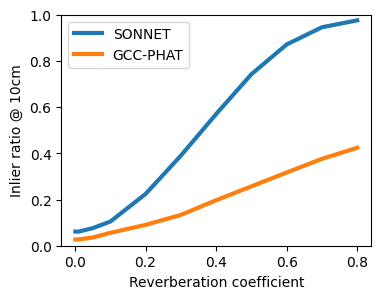

In [5]:
plt.figure(figsize=(4,3))
for model_name in models:
    plt.plot(config_eval.reverberations_levels,[np.sum(np.abs(residuals[model_name][reverb_i,:]) < 5)/residuals[model_name].shape[1] for reverb_i,reverb in enumerate(config_eval.reverberations_levels)],linewidth=3)
    #plt.title(model_name)
    plt.xlabel("Reverberation coefficient")
    plt.ylabel("Inlier ratio @ 10cm")
    plt.ylim(0,1)
    plt.legend(models)
    #plt.plot(np.std(residuals[model_name][:,:1225],axis=1))
    #plt.hist(residuals[model_name][8,:],100)

In [6]:
residuals = {model_name : np.zeros((len(config_eval.snr_levels), config_eval.n_rooms_simulate*(config_eval.n_mics*(config_eval.n_mics-1))//2 )) for model_name in models}

with h5py.File(dataset_path, "r") as hdf5_file:
#with h5py.File("results/datasets/eval_old.hdf5", "r") as hdf5_file:

    dX = hdf5_file["input"]
    dY = hdf5_file["gt"]
    
    for i in range(len(config_eval.snr_levels)):
    #for i in [8]:#range(2):
        print("new_noise")
        d = DatasetTDE_eval(dX[:,config_eval.reverb_at_snr_dependency_measuring],dY)
        dl = torch.utils.data.DataLoader(d, batch_size=config_train.batch_size)
        counter = 0
        for X,y in dl:
            print("-")
            X += X.std(dim=2,keepdim=True)/10**(config_eval.snr_levels[i]/20)
            X,y = X.to(config_eval.device),y.to(config_eval.device)
            for j, model_name in enumerate(models):
                res = models[model_name](X).argmax(1) - (y + 500)
                residuals[model_name][i,counter: counter + X.shape[0]] = res.cpu()
            counter += X.shape[0]

        


new_noise
-
new_noise
-
new_noise
-
new_noise
-
new_noise
-
new_noise
-
new_noise
-
new_noise
-
new_noise
-
new_noise
-
new_noise
-
new_noise
-
new_noise
-


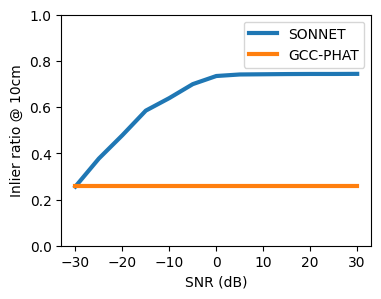

In [7]:
plt.figure(figsize=(4,3))
for model_name in models:
    plt.plot(config_eval.snr_levels,[np.sum(np.abs(residuals[model_name][snr_i,:]) < 5)/residuals[model_name].shape[1] for snr_i,snr in enumerate(config_eval.snr_levels)],linewidth=3)
    #plt.title("Noise sensitivity @reverb_coeff = 0.55")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Inlier ratio @ 10cm")
    plt.ylim(0,1)
    plt.legend(models)